In [1]:
import numpy as np
import xarray as xr
import gcsfs
from matplotlib import pyplot as plt
from xgcm import Grid
from xhistogram.xarray import histogram
%matplotlib inline
from matplotlib import colors as cols

In [2]:
from intake import open_catalog
cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/channel.yaml")
ds01  = cat["channel_ridge_resolutions_01km"].to_dask()

In [3]:
grid01 = Grid(ds01, periodic='X')

In [5]:
horispace01 = 1e3
horispace05 = 5e3
horispace20 = 20e3
time_index = 0
depth = -50
f =  -0.83e-4
daytime = 86400
alpha = 2e-4
gravity = 9.81
dx = 1e3

In [6]:
u = grid01.interp(ds01.U,'X')
v = grid01.interp(ds01.V,'Y', boundary='extend')

In [7]:
ux = grid01.diff(ds01.U,'X')/dx
vy = grid01.diff(ds01.V,'Y', boundary='extend')/dx
uy = grid01.interp(grid01.interp(grid01.diff(ds01.U,'Y', boundary='extend')/dx, 'X'),
                 'Y', boundary='extend')
vx = grid01.interp(grid01.interp(grid01.diff(ds01.V,'X')/dx, 'X'),
                 'Y', boundary='extend')

In [8]:
speed = (u**2 + v**2)**0.5

In [9]:
curv = (u**2*vx - v**2*uy + u*v*(vy- ux))/speed**3

In [12]:
Cu = 2*speed/f*curv

In [10]:
vort = (vx - uy)/f

In [13]:
b = gravity*alpha*ds01['T']

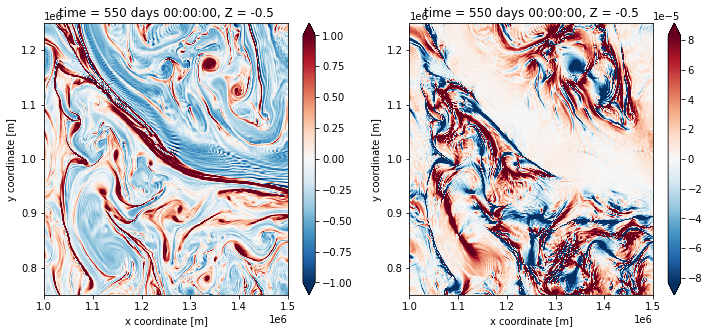

In [11]:
plt.figure(figsize=(12,5))

plt.subplot(121)
vort.isel(time=0, Z=0).sel(XC=slice(1000e3, 1500e3), YC=slice(750e3, 1250e3)).plot(vmin=-1)

plt.subplot(122)
curv.isel(time=0, Z=0).sel(XC=slice(1000e3, 1500e3), YC=slice(750e3, 1250e3)).plot(vmin=f)

In [14]:
gradb2 = (grid01.interp(grid01.diff(b, 'X'),'X')/horispace01)**2 + (
        grid01.interp(grid01.diff(b, 'Y', boundary='extend'),
                      'Y',boundary='extend')/horispace01)**2
N2 = grid01.interp(grid01.diff(b,'Z',boundary='extend'
                ) / grid01.diff(b.Z, 'Z', boundary='extend'),
                 'Z', boundary='extend')

In [15]:
uz = grid01.interp(grid01.diff(u,'Z',boundary='extend'
                ) / grid01.diff(u.Z, 'Z', boundary='extend'),
                 'Z', boundary='extend')

vz = grid01.interp(grid01.diff(v,'Z',boundary='extend'
                ) / grid01.diff(v.Z, 'Z', boundary='extend'),
                 'Z', boundary='extend')

In [16]:
Ri_geo = N2*f**2/gradb2
Ri = N2/ (uz**2 + vz**2)
Ro = vort

In [17]:
phi1 = (1 + Ro) 
phi2 = - (1+Cu)/Ri
phi2_geo = - (1 + Cu)/Ri_geo
phi = (phi1+phi2).rename('phi')
phi_geo = (phi1+phi2_geo).rename('phi_geo')
Lq = ( (1+Cu)*phi ).rename('Lq')
fq = (phi1 - 1/Ri).rename('fq')

In [18]:
fq_geo = (phi1 - 1/Ri_geo).rename('fq_geo')
Lq_geo = ( (1+Cu)*phi_geo).rename('Lq_geo')

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


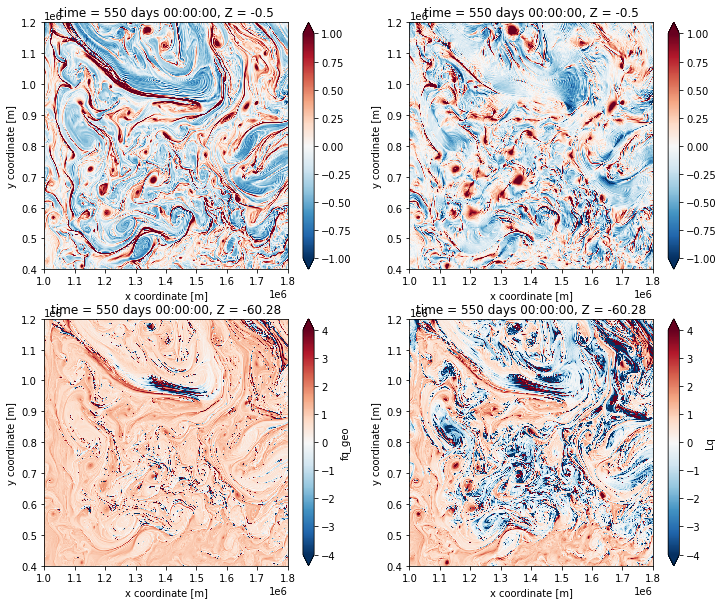

In [19]:
plt.figure(figsize=(12,10))

plt.subplot(221)
vort.isel(time=0, Z=0).sel(XC=slice(1000e3, 1800e3), YC=slice(400e3, 1200e3)).plot(vmin=-1)

plt.subplot(222)
Cu.isel(time=0, Z=0).sel(XC=slice(1000e3, 1800e3), YC=slice(400e3, 1200e3)).plot(vmin=-1)

plt.subplot(223)
fq_geo.isel(time=0).sel(Z=-60, method='nearest').sel(XC=slice(1000e3, 1800e3), 
                                                 YC=slice(400e3, 1200e3)).plot(vmin=-4)

plt.subplot(224)
Lq.isel(time=0).sel(Z=-60, method='nearest').sel(XC=slice(1000e3, 1800e3), 
                                                 YC=slice(400e3, 1200e3)).plot(vmin=-4)

In [20]:
depth = 0
vort01_0 = grid01.interp(grid01.interp((grid01.diff(ds01.V.sel(Z=depth,method='nearest'), 'X') - grid01.diff(ds01.U.sel(Z=depth,method='nearest'), 'Y', boundary='extend')),
                   'X'), 'Y', boundary='extend')/horispace01
vort01_0 = (vort01_0/f).rename('vorticity')

strain01_0 = ((grid01.diff(ds01.U.sel(Z=depth,method='nearest'), 'X') - grid01.diff(ds01.V.sel(Z=depth,method='nearest'), 'Y', boundary='extend'))**2 + 
          (grid01.interp(grid01.interp(grid01.diff(ds01.V.sel(Z=depth,method='nearest'), 'X') + grid01.diff(ds01.U.sel(Z=depth,method='nearest'), 'Y', boundary='extend'),
                       'X'), 'Y', boundary='extend'))**2)**0.5/horispace01
strain01_0 = (strain01_0/np.abs(f)).rename('strain')

In [21]:
import boost_histogram as bh
def bh_xhistogram(*args, bins):

    # Convert bins to boost-histogram axes first
    prepare_bins = (bh.axis.Variable(b) for b in bins)
    h = bh.Histogram(*prepare_bins)

    # We need flat NP arrays for filling
    prepare_fill = (np.asarray(a).flatten() for a in args)
    h.fill(*prepare_fill)

    # Now compute the xarray output.
    return xr.DataArray(h,
            name="_".join(a.name for a in args) + "_histogram",
            coords=[(f"{a.name}_bin", arr.flatten(), a.attrs)
                      for a, arr in zip(args, h.axes.centers)])

In [22]:
vort_bins = np.arange(-7,7,0.1)
strain_bins = np.arange(0,7,0.1)
fq_bins = np.arange(-20, 4, 0.3)

In [23]:
h_vort_strain_fqgeo = bh_xhistogram(vort01_0.sel(YC=slice(250e3,1750e3)),
                                  strain01_0.sel(YC=slice(250e3,1750e3)),
                                  fq_geo.sel(YC=slice(250e3,1750e3)).sel(Z=-50, method='nearest'),
                                  bins=[vort_bins, strain_bins, fq_bins])

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


In [26]:
h_vort_strain_Lqgeo = bh_xhistogram(vort01_0.sel(YC=slice(250e3,1750e3)),
                                  strain01_0.sel(YC=slice(250e3,1750e3)),
                                  Lq_geo.sel(YC=slice(250e3,1750e3)).sel(Z=-50, method='nearest'),
                                  bins=[vort_bins, strain_bins, fq_bins])

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


In [28]:
h_vort_strain = bh_xhistogram(vort01_0.sel(YC=slice(250e3,1750e3)),
                                  strain01_0.sel(YC=slice(250e3,1750e3)),
                                  bins=[vort_bins, strain_bins])

In [30]:
mean_instability_fqgeo = (h_vort_strain_fqgeo * h_vort_strain_fqgeo.fq_geo_bin).sum('fq_geo_bin')/h_vort_strain
mean_instability_Lqgeo = (h_vort_strain_Lqgeo * h_vort_strain_Lqgeo.Lq_geo_bin).sum('Lq_geo_bin')/h_vort_strain

In [31]:
x_line = np.linspace(0,7)

In [32]:
plt.rcParams.update({'font.size': 16})

In [34]:
### data from fig4.ipynb

hist01 = xr.open_dataarray('./hist01')
hist05 = xr.open_dataarray('./hist05')
hist20 = xr.open_dataarray('./hist20')

In [35]:
vortband01 = np.linspace(-7, 7, 240)
strainband01 = np.linspace(.5e-3, 7, 240)
binbox01 =  (vortband01[1]-vortband01[0])*(strainband01[1]-strainband01[0])
girbNums01 = 1000*2000

In [36]:
H01 = (1**2)/(binbox01*2000**2)*hist01.mean(dim='time')
mask = xr.where(H01>1e-5,1,0)

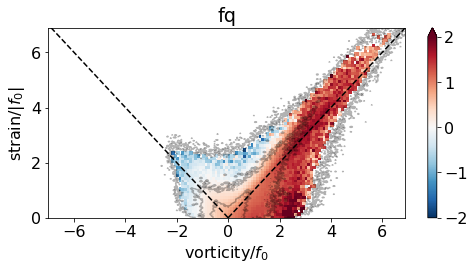

In [37]:
plt.figure(figsize=(8,3.5))

mean_instability_fqgeo.where(h_vort_strain>30).plot(x='vorticity_bin', vmin=-2, vmax=2, cmap='RdBu_r')
plt.plot(x_line, x_line, '--', color='k')
plt.plot(-x_line, x_line, '--', color='k')
plt.title('Lq, 50m', color='k')
plt.title('fq')
plt.xlabel('vorticity/$f_0$')
plt.ylabel('strain/$|f_0|$')

plt.contour(np.linspace(-7, 7, 239), np.linspace(.5e-3, 7, 239), ((1**2)/(binbox01*2000**2)*hist01.mean(dim='time').T), levels=[1e-5], colors='k', alpha=.3)
plt.contour(np.linspace(-7, 7, 239), np.linspace(.5e-3, 7, 239), ((5**2)/(binbox01*2000**2)*hist05.mean(dim='time').T), levels=[1e-5],colors ='k', alpha=.3)
plt.contour(np.linspace(-7, 7, 239), np.linspace(.5e-3, 7, 239),((20**2)/(binbox01*2000**2)*hist20.mean(dim='time').T), levels=[1e-5],colors ='k', alpha=.3)

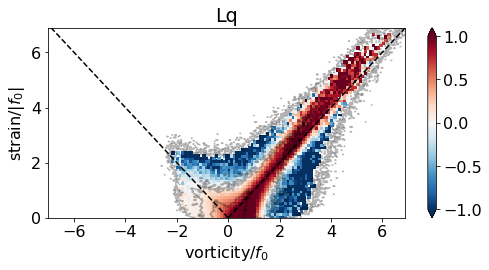

In [38]:
plt.figure(figsize=(8,3.5))

mean_instability_Lqgeo.where(h_vort_strain>30).plot(x='vorticity_bin', vmin=-1, vmax=1,  cmap='RdBu_r')
plt.plot(x_line, x_line, '--', color='k')
plt.plot(-x_line, x_line, '--', color='k')
plt.title('Lq, 50m', color='k')
plt.title('Lq')
plt.xlabel('vorticity/$f_0$')
plt.ylabel('strain/$|f_0|$')

plt.contour(np.linspace(-7, 7, 239), np.linspace(.5e-3, 7, 239), ((1**2)/(binbox01*2000**2)*hist01.mean(dim='time').T), levels=[1e-5], colors='k', alpha=.3)
plt.contour(np.linspace(-7, 7, 239), np.linspace(.5e-3, 7, 239), ((5**2)/(binbox01*2000**2)*hist05.mean(dim='time').T), levels=[1e-5],colors ='k', alpha=.3)
plt.contour(np.linspace(-7, 7, 239), np.linspace(.5e-3, 7, 239),((20**2)/(binbox01*2000**2)*hist20.mean(dim='time').T), levels=[1e-5],colors ='k', alpha=.3)

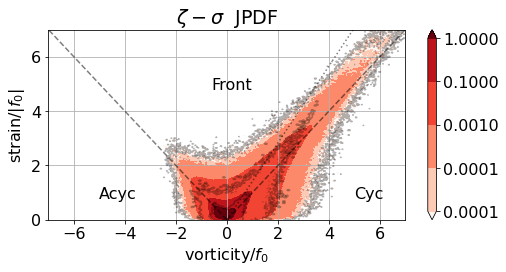

In [39]:
plt.figure(figsize=(8,3.5))

# girbNums01 = len(vort_01_0.YC)*len(vort_01_0.XC)
test = (1/(binbox01*girbNums01)*(hist01.rename('')).mean(dim='time').T)
test = xr.where(test<1e-5,np.nan,test)
# test.plot(vmax=1e2,norm=cols.SymLogNorm(1e-4), cmap ='Reds')

xr.plot.contourf(test,vmax=1e2,levels=[5e-5,1e-4,1e-3,1e-1, 1e0], cmap ='Reds')

# plt.contour(np.linspace(-7, 7, 59), np.linspace(.5e-3, 7, 59), binbox01*(1**2)*hab01_00.mean(dim='time').T, levels=[0.5e1,1.5e2,1e4],colors ='k')
# plt.title('1km')
plt.contour(np.linspace(-7, 7, 239), np.linspace(.5e-3, 7, 239), ((1**2)/(binbox01*2000**2)*hist01.mean(dim='time').T), levels=[1e-5], colors='k', alpha=.3)
plt.contour(np.linspace(-7, 7, 239), np.linspace(.5e-3, 7, 239), ((5**2)/(binbox01*2000**2)*hist05.mean(dim='time').T), levels=[1e-5],colors ='k', alpha=.3)
plt.contour(np.linspace(-7, 7, 239), np.linspace(.5e-3, 7, 239),((20**2)/(binbox01*2000**2)*hist20.mean(dim='time').T), levels=[1e-5],colors ='k', alpha=.3)
plt.plot(np.linspace(0,-7,10),np.linspace(0,7,10),'k--',alpha=.5)
plt.plot(np.linspace(0,7),np.linspace(0,7),'k--',alpha=.5)
plt.plot(np.linspace(0,7),np.sqrt(2)*np.linspace(0,7),'k:',alpha=.5)
plt.xlabel('vorticity/$f_0$')
plt.ylabel('strain/$|f_0|$')
plt.ylim(0,7)
plt.title('$\zeta-\sigma$  JPDF')

plt.text(-.6,4.8,'Front')
plt.text(5,.8,'Cyc')
plt.text(-5,.8,'Acyc')
plt.rc('grid', color='black', alpha=.3)
plt.grid()

In [40]:
## OW
ow = strain01_0**2 - vort01_0**2

In [41]:
div01_0 = (grid01.diff(ds01.U.sel(Z=depth,method='nearest'), 'X') + grid01.diff(ds01.V.sel(Z=depth,method='nearest'), 'Y', boundary='extend'))/horispace01
div01_0 = (div01_0/np.abs(f)).rename('div')

In [42]:
lambda_minus = (0.5*(div01_0 - (ow+0j)**0.5 )).rename('lambda_minus')

In [43]:
lambda_minus_real = (lambda_minus.real).rename('lambda_minus')

In [44]:
lam_bins = np.linspace(-5,1,50)

In [45]:
h_vort_strain_lambda = bh_xhistogram(vort01_0.sel(YC=slice(250e3,1750e3)),
                                  strain01_0.sel(YC=slice(250e3,1750e3)),
                                  lambda_minus_real.sel(YC=slice(250e3,1750e3)),
                                  bins=[vort_bins, strain_bins, lam_bins])

In [46]:
mean_instability_lam = (h_vort_strain_lambda * h_vort_strain_lambda.lambda_minus_bin).sum('lambda_minus_bin')/h_vort_strain


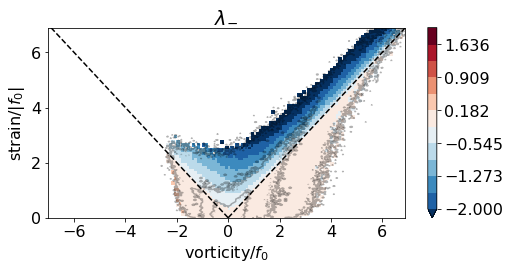

In [47]:
plt.figure(figsize=(8,3.5))

mean_instability_lam.where(h_vort_strain>10).plot(x='vorticity_bin', vmin=-2, levels=12, cmap='RdBu_r')
plt.plot(x_line, x_line, '--', color='k')
plt.plot(-x_line, x_line, '--', color='k')
plt.title('$\lambda_{-}$ ')

plt.xlabel('vorticity/$f_0$')
plt.ylabel('strain/$|f_0|$')

plt.contour(np.linspace(-7, 7, 239), np.linspace(.5e-3, 7, 239), ((1**2)/(binbox01*2000**2)*hist01.mean(dim='time').T), levels=[1e-5], colors='k', alpha=.3)
plt.contour(np.linspace(-7, 7, 239), np.linspace(.5e-3, 7, 239), ((5**2)/(binbox01*2000**2)*hist05.mean(dim='time').T), levels=[1e-5],colors ='k', alpha=.3)
plt.contour(np.linspace(-7, 7, 239), np.linspace(.5e-3, 7, 239),((20**2)/(binbox01*2000**2)*hist20.mean(dim='time').T), levels=[1e-5],colors ='k', alpha=.3)